James Cole  
Final project for EPPS 6317   
# LIDAR Scanner Control and Data Visualization in Python  

**Version 2**  

This program will collect LIDAR measurements and servo positions from Arduino microcontrollers conencted to serial ports and create an interactive point cloud visualization using PyVista. Users can either run a scan or import data from a CSV file.   

Out-of-the box data collection requires a [Garmin LIDAR-Lite v4](https://www.sparkfun.com/products/18009) module attached to a pan/tilt mount, but data can be imported form prior scans by skipping to Step 2b below after importing packages (Step 1). 

## 1. Import packages and get serial port info

### Import packages

In [1]:
import time
import pandas as pd
import serial
import serial.tools.list_ports
import math
import os
import numpy as np
import pyvista as pv
from pyvistaqt import BackgroundPlotter

### Get serial port info
Use pyserial to list serial port details. These will be used to listen for data printed to the serial monitor.

In [2]:
# Show ports
ports = list(serial.tools.list_ports.comports())
for item in ports:
    print( item.name )
    print( item.description )
    print( item.hwid )
    print( item.vid )
    print( item.pid )
    print( item.serial_number )
    print( item.location )
    print( item.manufacturer )
    print( item.product )
    print( item.interface )

cu.Bluetooth-Incoming-Port
n/a
n/a
None
None
None
None
None
None
None


## 2a. Run scan 
Collect data from two serial ports. Only works with device attached.     
Skip if importing data.

In [ ]:
# Declare ports
PORT_1 = serial.Serial('/dev/cu.usbmodemDC5475C4BCD02', 115200)  # Lidar
PORT_2 = serial.Serial('/dev/cu.usbserial-110', 115200)  # Servos

if PORT_1 and PORT_2:
    print("Ports connected")

In [ ]:
# Listen to serial ports and combine in a DataFrame
run = True
data = []
scanTime = 0

def newLidar():
    print("Scanning...")
    while run:
        
        new_row = []
        lidar = PORT_1.readline()
        new_row.append(lidar)
        servos = PORT_2.readline()
        new_row.append(servos)

        if servos == b'000\r\n':
            print("——————————————————————————————")
            print("        Scan complete")
            print("——————————————————————————————")
            break
        else:
            data.append(new_row)
            print(new_row)

# Run scan
start = time.time()
PORT_2.write(1)

newLidar()

end = time.time()
scanTime = round(end-start, 2)

df = pd.DataFrame(data)
# df.head()

# Clean the data
df[0] = df[0].astype(str).str.replace('\D', '')
df[1] = df[1].astype(str).str.replace('\D', '')

df[0] = df[0].astype(str).str.replace('\r\n', '')
df[1] = df[1].astype(str).str.replace('\r\n', '')

# Use xyz values
df_copy2 = df.copy()
df_copy2[1] = df_copy2[1].astype(str).str.split('\t')
df_copy2[2] = 0
xvals = []
yvals = []
zvals = []
df_copy2.tail()

for i in df_copy2[1]:
    x = i[0]
    y = i[1]
    xvals.append(x)
    yvals.append(y)

for i in df_copy2[0]:
    zvals.append(i)

xyz = pd.DataFrame(
    {'x': xvals,
     'y': yvals,
     'z': zvals
    })

print(f"LIDAR points collected: {len(xyz)}")
print(f"Total scan time: {scanTime} seconds")

xyz.head()

## 2b. Import data
Skip if collecting data.

In [3]:
# Import data
df = pd.read_csv('./data-exports/raw-sensor-data-livingRoom.csv')
df.head()

# Make DF with xyz values
df_copy2 = df.copy()
df_copy2["1"] = df_copy2["1"].astype(str).str.split('\t')
df_copy2["2"] = 0
xvals = []
yvals = []
zvals = []
df_copy2.tail()

for i in df_copy2["1"]:
    x = i[0]
    y = i[1]
    xvals.append(x)
    yvals.append(y)

for i in df_copy2["0"]:
    zvals.append(i)

xyz = pd.DataFrame(
    {'x': xvals,
     'y': yvals,
     'z': zvals
    })

xyz.head()

,x,y,z
0,0,45,0.12
1,3,45,0.13
2,6,45,0.12
3,9,45,0.15
4,12,45,0.13


### Convert Cartesian coordinates to spherical coordinates

r = radius   
θ (theta) = inclination (pitch angle)  
φ (phi) = azimuth (yaw angle)

x = rsinθ cosφ  
y = rsinθ sinφ   
z = rcosθ

In [4]:
# Get spherical coordinates
def make_spherical(xpos, ypos, distance):
    # Variables
    # xpos = servo yaw angle between 0 and 180
    # ypos = lidar pitch angle between 0 and 360
    # distance = lidar distance reading
    pi = math.pi

    theta = float((xpos * pi) / 180)  # pan servo
    phi = float((ypos * pi) / 180)  # tilt servo

    z = distance * math.sin(phi)
    x = z * math.cos(phi) * math.cos(theta)
    y = z * math.cos(phi) * math.sin(theta)
    
    return [x, y, z]

# Get angle and distance
new_data = []

for index, row in xyz.iterrows():
    # print(row[0], row[1])
    new_row = []

    z = float(row[2])
    new_row.append(z)

    y = float(row[1])
    new_row.append(y)
    
    x = float(row[0])
    new_row.append(x)
    
    spherical_data = make_spherical(new_row[2], new_row[1], new_row[0])
    new_row = spherical_data

    new_data.append(new_row)

point_cloud_data = pd.DataFrame(new_data)
point_cloud_data = point_cloud_data.rename(columns={0: "x", 1: "y", 2: "z"})
point_cloud_data.head()

# Convert data for PyVista
points = point_cloud_data.to_numpy()
points

# Create point cloud
point_cloud = pv.PolyData(points)

### Export data
Skip if not exporting data. 

Uncomment and run if exporting data. 

In [5]:
# # Handle directory
# os.makedirs('./data-exports', exist_ok=True) 

# # Export raw sensor data
# df.to_csv('./data-exports/raw-sensor-data.csv', index=False)  

# # Export spherical data
# point_cloud_data.to_csv('./data-exports/spherical-data.csv', index=False)  

## 3. Create PyVista plots

In [5]:
# Set plot theme styles
pv.global_theme.background = 'black'
pv.global_theme.font.color = 'grey'

#### Basic plot
Render a point cloud plot in the notebook.

/Users/jamescole/anaconda3/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


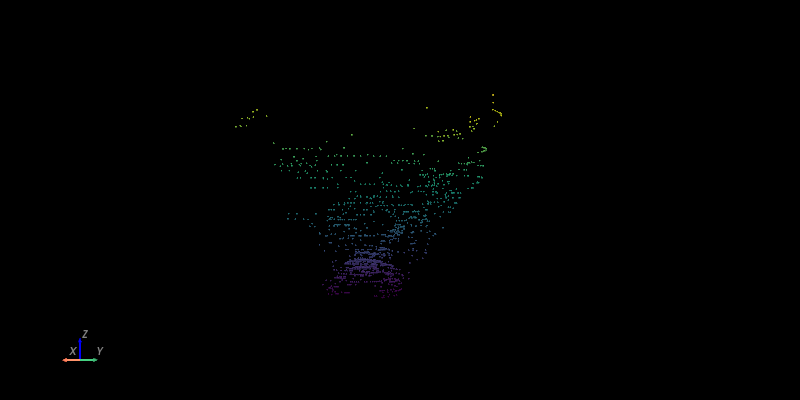

In [6]:
# Basic plot
pl = pv.Plotter(notebook=True)
pl.add_mesh(point_cloud, 
            render_points_as_spheres = True,
            scalars = points[:, 2],
            point_size = 2,
            show_scalar_bar = False,
            )
camera = pv.Camera()
pl.camera = camera
pl.camera_position = 'yz'
pl.window_size = [800, 400]
pl.camera.azimuth = 45
pl.add_axes()
pl.show()


#### Interactive 3D plot
Render point cloud in new window. User can navigate around the point cloud. 

In [7]:
rgba = points - points.min(axis=0)
rgba /= rgba.max(axis=0)

plotter = BackgroundPlotter()
plotter.add_mesh(point_cloud, scalars=rgba, rgba=True, point_size=3)

plotter.add_axes()

<vtkmodules.vtkRenderingAnnotation.vtkAxesActor(0x2a30f3de0) at 0x17ee6b220>